# Exercise 7
## Fundamentals of Machine Learning, WiSe 20/21
### Authors: Catherine Knobloch, Elias Olofsson, Julia Siegl
    Version information:
        2021-02-12: v.1.0. First public release. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')

from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.sparse.linalg import spsolve

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

# 4. Fitting Circles

(2431, 2)


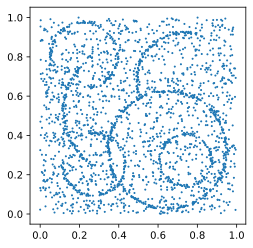

In [2]:
# Import the data
data = np.load("circles.npy")
print(data.shape)

# Visualize in scatter plot
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

As a human, I could probably fit 6-7 circles by visual identification from this scatter plot.

## 4.1 RANSAC (6 pts)
Fitting a circle from three points in 2D, using the method found [here](https://math.stackexchange.com/a/1460096). 

In [3]:
def fit_circle(X):
    """
    Fit a circle from 3 points in 2D.
    
    Parameters:
    -----------
    X: np.array shape=(3,2)
        Array containing the points.
    
    Returns:
    --------
    model: np.array shape=(3,)
        Circle parameters. X and Y position of circle
        center, and radius of the circle.
    """
    # Need to check that the three points do not 
    # lie on a straight line.
    if np.abs(np.cross(X[1]-X[0], X[2]-X[0])) < 1e-4:
        return False
        
    # Form matrix A
    Xnorm = np.sum(X**2,axis=1)[:,None]
    ones  = np.ones(3)[:,None]
    A     = np.concatenate((Xnorm, X, ones), axis=1)
    
    # Matrix minors
    A1 = np.linalg.det(np.delete(A, 0, 1))
    A2 = np.linalg.det(np.delete(A, 1, 1))
    A3 = np.linalg.det(np.delete(A, 2, 1))
    A4 = np.linalg.det(np.delete(A, 3, 1))
    
    # Calc circle center and radius
    cx = 0.5*A2/A1
    cy = -0.5*A3/A1
    r  = np.sqrt(cx**2 + cy**2 + A4/A1)
    
    return np.array([cx,cy,r])

In [4]:
def dist_circle(X, model):
    """
    Calculate distances from data set to fitted circle.
    """
    return np.abs(np.sqrt((X[:,0]-model[0])**2+(X[:,1]-model[1])**2)-model[2])

In [5]:
def RANSAC(X, D, T, eps, fit_model, dist_func):
    """
    General purpose RANSAC-algorithm.
    
    Parameters:
    -----------
    X: np.array 
        Feature matrix, each row corresponding to a data instance. 
    D: int
        No. of data points required to fit the chosen model.
    T: int
        No. of RANSAC iterations.
    eps: float
        Threshold for inlier determination.
    fit_model: function
        Function to fit a certain model. Shall take one array
        of D data points, and output the model. If no fit 
        could be found, return False.
    dist_func:
        Function to determine distance from model to all data
        points. Shall input the matrix X, the model and return
        an array of real, positive distances.
    
    Returns:
    --------
    best_model: np.array
        Array containing the parameters of the best fitted model.
    inliers: np.array
        Boolean mask corresponding to X, where True elements are
        considered inliers to best_model.
    """
    max_inliers = 0
    for i in range(T):
        # Random subset of D points.
        X_subset = X[np.random.choice(len(X), size=D, replace=False)]
        
        # Fit the model to the points.
        model = fit_model(X_subset)
        
        # If valid model was found:
        if np.any(model):
            # Find distances from all data points to the model.
            distances = dist_func(X, model)
            
            # Count the inliers of the model.
            inlier_current = distances < eps
            inlier_count   = inlier_current.sum()
            
            # If current model has more inliers than the previous 
            # record, save the model.
            if inlier_count > max_inliers:
                max_inliers = inlier_count
                inliers     = inlier_current
                best_model  = model 
                
    return best_model, inliers

In [6]:
# Estimate the minimum number of RANSAC iterations required.
alpha = 0.99  # Probability of RANSAC success. 
gamma = 0.05  # Inlier fraction.
D     = 3     # No. of data points required to fit chosen model.
T     = np.round(np.log(1-alpha)/np.log(1-gamma**D)).astype('int')
print(f"Estimated minimum no. of RANSAC iterations: {T}")

Estimated minimum no. of RANSAC iterations: 36839


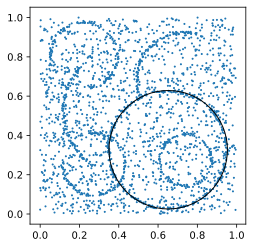

In [7]:
# Parameters
eps = 0.01   # Inlier threshold

# Fit a single circle
model, inliers = RANSAC(data, D, T, eps, fit_circle, dist_circle)

# Visualize underlying data in scatter plot
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# Plot fitted circle.
circ = plt.Circle((model[0],model[1]), radius=model[2], fill=False)
plt.gca().add_patch(circ)

plt.show()

### Fit multiple circles, by sequentially removing set of fitted inliers.

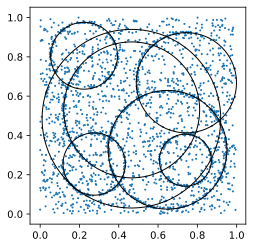

In [8]:
# Parameters
eps       = 0.01    # Inlier threshold
N_circles = 7       # No. circles to fit

# Relabel the dataset.
X = data

# Visualize underlying data in scatter plot.
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

X_list = []

# For each circle
for i in range(N_circles):
    # Find best fit. 
    model, inliers = RANSAC(X, D, 10*T, eps, fit_circle, dist_circle)
    
    # Plot the fitted circle in the diagram.
    circ = plt.Circle((model[0],model[1]), radius=model[2], fill=False)
    plt.gca().add_patch(circ)

    # Save set of inliers
    X_list.append(X[inliers].copy())

    # Remove current model's inliers from the dataset.     
    X = X[~inliers].copy()

plt.show()

## 4.2 Algebraic Distance (4 pts)

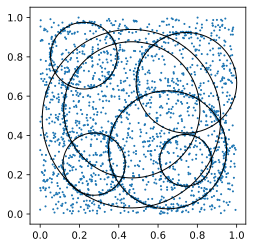

In [10]:
# Visualize underlying data in scatter plot.
plt.scatter(data[:,0],data[:,1], marker='.', s=5)
plt.gca().set_aspect('equal', adjustable='box')

# For each set of inliers associated with a circle from RANSAC
for X in X_list:
    # Transform of X and Y
    Xt = np.concatenate((X,np.ones(len(X))[:,None]), axis=1)
    Yt = np.sum(X**2, axis=1)
    
    # Solve OLS problem
    beta = np.linalg.solve((Xt.T @ Xt), Xt.T @ Yt)
    
    # Transform back to get circle parameters
    cx = 0.5*beta[0]
    cy = 0.5*beta[1]
    r  = np.sqrt(beta[2] + cx**2 + cy**2)
    
    # Plot the fitted circle in the diagram.
    circ = plt.Circle((cx, cy), radius=r, fill=False)
    plt.gca().add_patch(circ)

plt.show()

## 4.3 Levenberg-Marquardt (6 pts)